# VBF exploration
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- makes mjj and $\eta_{ij}$ and plots to seperate ggF and VBF

In [1]:
import glob
import os
import json
import pickle
import yaml

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
! ls ../eos/Apr12_presel_2017/

DYJetsToLL_M-10to50                     SingleElectron_Run2017E
DYJetsToLL_Pt-100To250                  SingleElectron_Run2017F
DYJetsToLL_Pt-250To400                  SingleMuon_Run2017B
DYJetsToLL_Pt-400To650                  SingleMuon_Run2017C
DYJetsToLL_Pt-50To100                   SingleMuon_Run2017D
DYJetsToLL_Pt-650ToInf                  SingleMuon_Run2017E
GluGluHToTauTau                         SingleMuon_Run2017F
GluGluHToWW_Pt-200ToInf_M-125           TTTo2L2Nu
GluGluZH_HToWW_ZTo2L_M-125              TTToHadronic
HWminusJ_HToWW_M-125                    TTToSemiLeptonic
HWplusJ_HToWW_M-125                     VBFHToWWToLNuQQ_M-125_withDipoleRecoil
HZJ_HToWW_M-125                         WJetsToLNu_HT-100To200
QCD_Pt_1000to1400                       WJetsToLNu_HT-1200To2500
QCD_Pt_1400to1800                       WJetsToLNu_HT-200To400
QCD_Pt_170to300                         WJetsToLNu_HT-2500ToInf
QCD_Pt_1800to2400                       WJetsToLNu_HT-400To600
QCD_Pt_2400to32

In [5]:
presel = {
    "mu": {
        ### part of the preselection
        "lep_fj_dr": "( ( lep_fj_dr>0.03) )",  
    },
    "ele": {
        ### part of the preselection
        "lep_fj_dr": "( ( lep_fj_dr>0.03) )",      
    }    
}

weights = {
    "ele": {
        "weight_L1Prefiring": 1,
        "weight_genweight": 1,
        "weight_id_electron": 1,
        "weight_pileup": 1,
        "weight_reco_electron": 1,
        "weight_trigger_electron": 1,
        "weight_vjets_nominal": 1,
    },
    "mu": {
        "weight_L1Prefiring": 1,
        "weight_genweight": 1,
        "weight_id_muon": 1,
        "weight_isolation_muon": 1,
        "weight_pileup": 1,
        "weight_trigger_iso_muon": 1,
        "weight_trigger_noniso_muon": 1,
        "weight_vjets_nominal": 1   ,
    },       
}

In [11]:
years = ["2017"] #, "2016", "2016APV", "2018"]
channels = ["mu", "ele"]

samples_dir = f"../eos/Apr12_presel_"

samples = [
    "HWW", 
#     "VH",
    "VBF",
#     "ttH",
#     "QCD",
#     "DYJets",
#     "WJetsLNu",
#     "WZQQ",
#     "TTbar",
#     "SingleTop",
#     "Diboson",
#     "Data"
]

In [12]:
from make_hists import make_events_dict
events_dict = make_events_dict(years, channels, samples_dir, samples, presel, weights, "all", add_inclusive_score=True,
                                  apply_tagger=0.99,
#                                   apply_inverse_tagger=0.99,
                                 )

ATTENTION: WJetsToLNu_HT-100To200 will be skipped
ATTENTION: DYJetsToLL_Pt-400To650 will be skipped
Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
---> Applying preselection.
applying lep_fj_dr selection on 1509 events
---> Done with preselection.
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will apply tagger cut of score>0.99
Will fill the VBF dataframe with the remaining 314 events
tot event weight 15.48593979702003 

ATTENTION: HWminusJ_HToWW_M-125 will be skipped
ATTENTION: WJetsToLNu_HT-800To1200 will be skipped
ATTENTION: TTToSemiLeptonic will be skipped
ATTENTION: DYJetsToLL_Pt-250To400 will be skipped
ATTENTI

In [13]:
events_dict.keys()

dict_keys(['2017'])

In [14]:
events_dict["2017"].keys()

dict_keys(['mu', 'ele'])

In [15]:
events_dict["2017"]["mu"].keys()

dict_keys(['VBF', 'HWW'])

# ggF and VBF

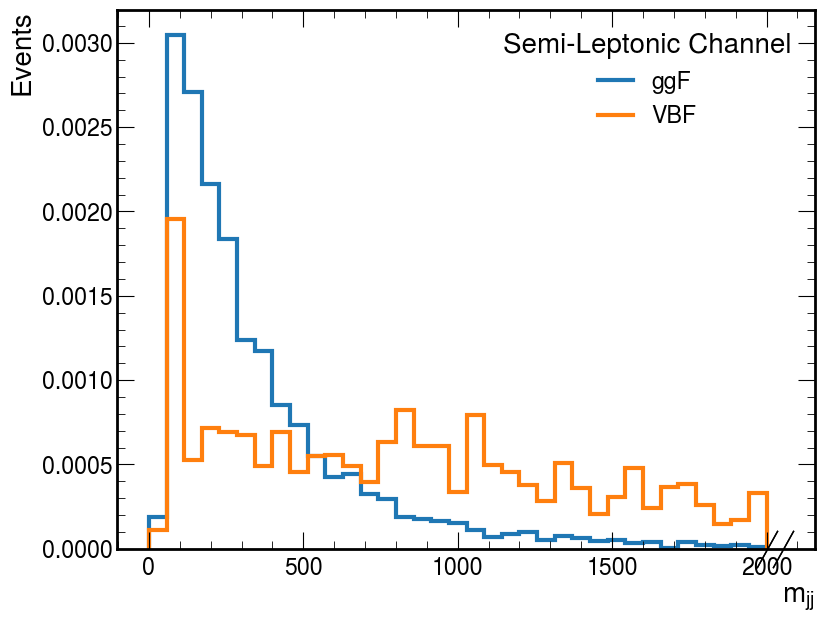

In [18]:
plt.rcParams.update({"font.size": 20})

samples_to_plot = [
    "HWW", 
    "VBF",
]

var = "mjj"

h = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),
    utils.axis_dict[var],
)  
    
fig, ax = plt.subplots(figsize=(9, 7))

for sample in samples_to_plot:
  
    for year in years:
        for ch in channels:

            df = events_dict[year][ch][sample]

            # tagger cut
            df = df[df["inclusive_score"]>0.9]

    #         df = df[df["lep_fj_dr"]>0.03]        
    #         df = df[df["n_bjets_M"]<2]
    #         df = df[(df["rec_W_lnu_pt"]/df["rec_W_qq_pt"])<4.8]

            h.fill(
                samples=sample,
                var=df[var],
                weight=df["event_weight"]
            )

for sample in samples_to_plot:
    if sample in utils.sig_labels:
        lab = utils.sig_labels[sample]
    else:
        lab = sample
        
    hep.histplot(
        h[{"samples":sample}],
        ax=ax,
        label=lab,
        linewidth=3,
        density=True
    )

# ax.set_title("Without dR(Jet,Lepton)>0.03")
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel("Events");  

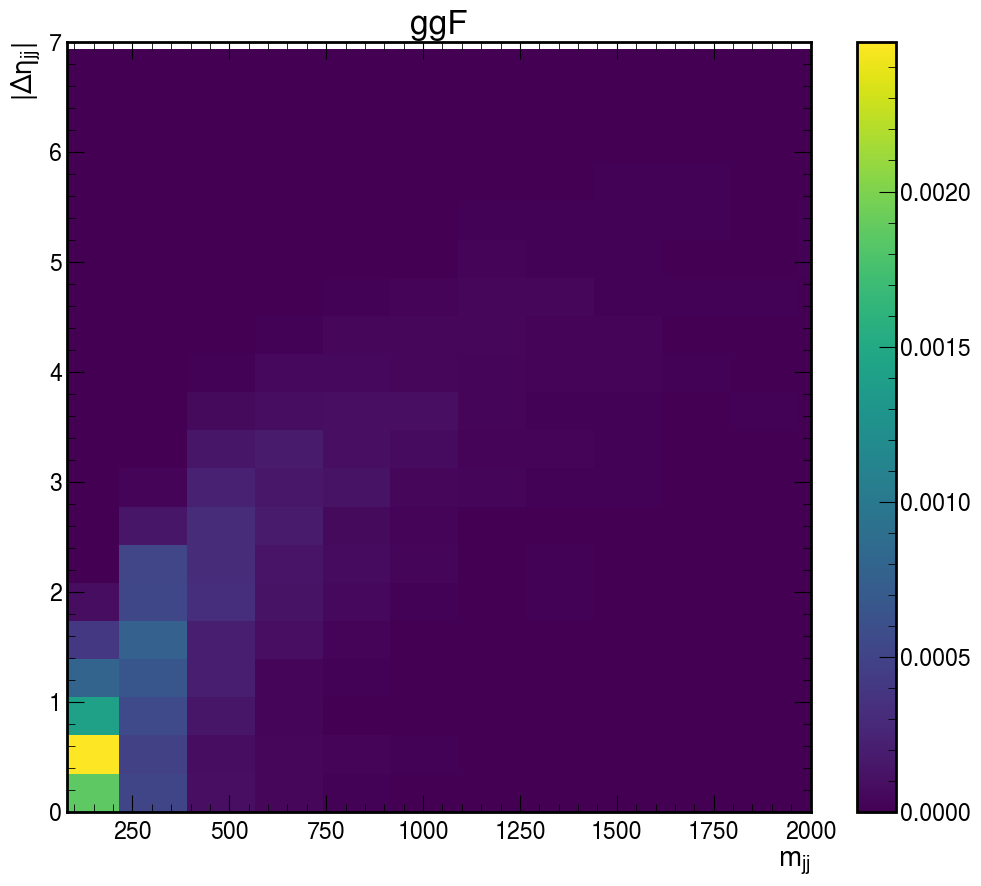

In [20]:
samples_to_plot = [
    "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
#      "QCD",
#     "DYJets",
#     "WJetsLNu",
#     "TTbar",
]

var1 = "mjj"
var2 = "deta"

from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(12, 10))

for sample in samples_to_plot:
    
    for year in years:
        for i, ch in enumerate(channels):
            df = events_dict[year][ch][sample]
            df = df[df["inclusive_score"]>0.9]

            if i==0:
                dff = df
            else:
                dff = pd.concat([dff, df])


    x = dff[var1].dropna()
    y = dff[var2].dropna()

    plt.hist2d(
        x,
        y,
        density=True,
#         norm=LogNorm(),
        bins=[30,20]
          )

ax.set_xlim(80,2000)
ax.set_ylim(0, 7)
ax.set_xlabel(r"$m_{jj}$");
ax.set_ylabel(r"$|\Delta \eta_{jj}|$");
ax.set_title(utils.sig_labels[sample])
plt.colorbar()